In [617]:
import dask.dataframe as dd
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

import os

DATADIR = 'D:/Work/Github_Morphotopes/data'
OUTPUT_DIR = "D:/Work/Github_Morphotopes/data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

#working with only attributes we need for the buildings
gdf = gpd.read_parquet('D:/Work/Github_Morphotopes/data/dort_11_subset.parquet')

### Information about dort_11_subset


In [569]:
print(type(gdf))
print("Geometry column:", getattr(gdf, "geometry", None).name if hasattr(gdf, "geometry") else None)
print("CRS:", getattr(gdf, "crs", None))
print("Rows:", len(gdf))
print("Columns:", list(gdf.columns)[:10])
print("Bounds:", gdf.total_bounds if len(gdf) else "EMPTY")
print(gdf.head(2))

<class 'geopandas.geodataframe.GeoDataFrame'>
Geometry column: geometry
CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "ETRS89 / UTM zone 32N", "base_crs": {"type": "GeographicCRS", "name": "ETRS89", "datum_ensemble": {"name": "European Terrestrial Reference System 1989 ensemble", "members": [{"name": "European Terrestrial Reference Frame 1989"}, {"name": "European Terrestrial Reference Frame 1990"}, {"name": "European Terrestrial Reference Frame 1991"}, {"name": "European Terrestrial Reference Frame 1992"}, {"name": "European Terrestrial Reference Frame 1993"}, {"name": "European Terrestrial Reference Frame 1994"}, {"name": "European Terrestrial Reference Frame 1996"}, {"name": "European Terrestrial Reference Frame 1997"}, {"name": "European Terrestrial Reference Frame 2000"}, {"name": "European Terrestrial Reference Frame 2005"}, {"name": "European Terrestrial Reference Frame 2014"}, {"name": "European Terrestrial Reference Fram

### Calculating centroids for each building polygon


In [570]:
cents = gdf.centroid
cents

0        POINT (393644.52 5709024.967)
1       POINT (393440.711 5708374.273)
2       POINT (393547.866 5708303.725)
3       POINT (393494.896 5708454.399)
4       POINT (393843.178 5708299.417)
                     ...              
1161    POINT (393702.839 5708276.282)
1162    POINT (393712.234 5708319.179)
1163    POINT (393710.132 5708309.812)
1164    POINT (393722.479 5708326.375)
1165    POINT (393701.926 5708322.113)
Length: 1166, dtype: geometry

### Calculating grid from centroids


In [571]:
gdf['x'], gdf['y'] = cents.x, cents.y
gdf['id'] = gdf.index.values
data = gdf[["x", "y", 'id']]
data

,x,y,id
0,393644.520393,5.709025e+06,0
1,393440.710944,5.708374e+06,1
2,393547.866372,5.708304e+06,2
3,393494.895861,5.708454e+06,3
4,393843.177978,5.708299e+06,4
...,...,...,...
1161,393702.838729,5.708276e+06,1161
1162,393712.234188,5.708319e+06,1162
1163,393710.131551,5.708310e+06,1163
1164,393722.479483,5.708326e+06,1164


In [572]:
data[["x_100", "y_100"]] = np.around(data[["x", "y"]], decimals=-2)
grid = data[["id", "x_100", "y_100"]].groupby(["x_100", "y_100"]).count().reset_index()

C:\Users\Itrat\AppData\Local\Temp\ipykernel_27204\4289293720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["x_100", "y_100"]] = np.around(data[["x", "y"]], decimals=-2)
C:\Users\Itrat\AppData\Local\Temp\ipykernel_27204\4289293720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["x_100", "y_100"]] = np.around(data[["x", "y"]], decimals=-2)


In [573]:
grid

,x_100,y_100,id
0,393200.0,5707900.0,1
1,393200.0,5708300.0,1
2,393200.0,5708700.0,2
3,393200.0,5709000.0,1
4,393200.0,5709100.0,2
...,...,...,...
94,393900.0,5708600.0,2
95,393900.0,5708700.0,3
96,393900.0,5708800.0,5
97,393900.0,5708900.0,3


### Clustering with 400m buffer


In [574]:
dbscan = DBSCAN(400, n_jobs=-1).fit(grid[["x_100", "y_100"]], sample_weight=grid["id"])
dbscan.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [575]:
# adding db.scan labels to grid as labels
grid["labels"] = dbscan.labels_

In [576]:
print(grid["labels"].nunique(), "clusters (including noise)")
print("Noise points:", (grid["labels"] == -1).sum())

1 clusters (including noise)
Noise points: 0


In [577]:
grid["labels"] 
grid

,x_100,y_100,id,labels
0,393200.0,5707900.0,1,0
1,393200.0,5708300.0,1,0
2,393200.0,5708700.0,2,0
3,393200.0,5709000.0,1,0
4,393200.0,5709100.0,2,0
...,...,...,...,...
94,393900.0,5708600.0,2,0
95,393900.0,5708700.0,3,0
96,393900.0,5708800.0,5,0
97,393900.0,5708900.0,3,0


###  Attaching clusters back to each building


In [578]:
data = pd.merge(data, grid, "left", on=["x_100", "y_100"])

In [579]:
print(len(data), "rows after merge (should match before)")
print(data["labels"].isna().sum(), "rows with NaN labels")

1166 rows after merge (should match before)
0 rows with NaN labels


In [580]:
data

,x,y,id_x,x_100,y_100,id_y,labels
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0
...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0


###  Counting buildings per cluster_label


In [581]:
counts = data.labels.value_counts()
counts

#each label has some buildings. label 0 has the most buildings

labels
0    1166
Name: count, dtype: int64

## Separating core labels from non-core labels


###  Core_In data


In [582]:
data["core"] = data.labels.isin(counts[counts > 100].index.drop(-1, errors="ignore"))
data

,x,y,id_x,x_100,y_100,id_y,labels,core
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True
...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True


In [583]:
cores = data[data.core]
cores

,x,y,id_x,x_100,y_100,id_y,labels,core
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True
...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True


###  Core_In Grid


In [584]:
grid["core"] = grid.labels.isin(counts[counts > 100].index.drop(-1, errors="ignore"))
grid_cores = grid[grid.core]
grid


,x_100,y_100,id,labels,core
0,393200.0,5707900.0,1,0,True
1,393200.0,5708300.0,1,0,True
2,393200.0,5708700.0,2,0,True
3,393200.0,5709000.0,1,0,True
4,393200.0,5709100.0,2,0,True
...,...,...,...,...,...
94,393900.0,5708600.0,2,0,True
95,393900.0,5708700.0,3,0,True
96,393900.0,5708800.0,5,0,True
97,393900.0,5708900.0,3,0,True


In [585]:
grid_cores


,x_100,y_100,id,labels,core
0,393200.0,5707900.0,1,0,True
1,393200.0,5708300.0,1,0,True
2,393200.0,5708700.0,2,0,True
3,393200.0,5709000.0,1,0,True
4,393200.0,5709100.0,2,0,True
...,...,...,...,...,...
94,393900.0,5708600.0,2,0,True
95,393900.0,5708700.0,3,0,True
96,393900.0,5708800.0,5,0,True
97,393900.0,5708900.0,3,0,True


###  Converting grid with core into geometry_points


In [586]:
grid_cores = gpd.GeoDataFrame(
    grid_cores["labels"],
    geometry=gpd.points_from_xy(grid_cores["x_100"], grid_cores["y_100"]),
    crs=25832
)

In [587]:
grid_cores
print(grid_cores.crs)          # should be EPSG:25832
print(len(grid_cores))         # ~ number of core cells
print(grid_cores.geometry.iloc[0].geom_type)  # 'Point'

EPSG:25832
99
Point


In [588]:
grid_cores

,labels,geometry
0,0,POINT (393200 5707900)
1,0,POINT (393200 5708300)
2,0,POINT (393200 5708700)
3,0,POINT (393200 5709000)
4,0,POINT (393200 5709100)
...,...,...
94,0,POINT (393900 5708600)
95,0,POINT (393900 5708700)
96,0,POINT (393900 5708800)
97,0,POINT (393900 5708900)


###  Merging all core points


In [589]:
grid_cores_dissolved = grid_cores.dissolve("labels")

###  Downloading geopackage: core_points as dissolved and undissolved

In [590]:
# Path to save
points_path = f"{OUTPUT_DIR}/grid_cores_points.gpkg"
dissolved_path = f"{OUTPUT_DIR}/grid_cores_dissolved.gpkg"

# Save the points version
grid_cores.to_file(points_path, layer="points", driver="GPKG")

# Dissolve points by cluster label
grid_cores_dissolved = grid_cores.dissolve(by="labels")
grid_cores_dissolved.to_file(dissolved_path, layer="dissolved", driver="GPKG")

print("Saved:")
print(points_path)
print(dissolved_path)

Saved:
D:/Work/Github_Morphotopes/data/grid_cores_points.gpkg
D:/Work/Github_Morphotopes/data/grid_cores_dissolved.gpkg


###  Non_core: selecting from grid

In [98]:
grid_non_cores = grid[~grid.core]
grid_non_cores

,x_100,y_100,id,labels,core
13,382700.0,5708200.0,1,-1,False
14,382700.0,5708300.0,1,-1,False
541,385500.0,5704700.0,1,-1,False
604,385700.0,5712500.0,2,-1,False
667,385900.0,5711800.0,2,1,False
...,...,...,...,...,...
14610,403500.0,5711700.0,4,9,False
14816,404700.0,5712100.0,1,10,False
14846,404900.0,5711900.0,3,10,False
14863,405000.0,5711900.0,1,10,False


###  Converting non-core into geometry_points

In [99]:
grid_non_cores = gpd.GeoDataFrame(
    grid_non_cores["labels"],
    geometry=gpd.points_from_xy(grid_non_cores["x_100"], grid_non_cores["y_100"]),
    crs=25832
)

###  Seperating non-core -1 and positive values

In [100]:
grid_non_cores_clustered = grid_non_cores[grid_non_cores.labels != -1]
grid_non_cores_outliers = grid_non_cores[grid_non_cores.labels == -1]

In [101]:
grid_non_cores_outliers

,labels,geometry
13,-1,POINT (382700 5708200)
14,-1,POINT (382700 5708300)
541,-1,POINT (385500 5704700)
604,-1,POINT (385700 5712500)
2253,-1,POINT (388300 5702600)
2254,-1,POINT (388300 5703000)
3997,-1,POINT (390700 5716500)
4467,-1,POINT (391400 5700300)
7556,-1,POINT (394300 5697400)


In [102]:
grid_non_cores_clustered 

,labels,geometry
667,1,POINT (385900 5711800)
705,1,POINT (386000 5711700)
743,2,POINT (386100 5710600)
744,1,POINT (386100 5711700)
2275,3,POINT (388300 5711400)
...,...,...
14610,9,POINT (403500 5711700)
14816,10,POINT (404700 5712100)
14846,10,POINT (404900 5711900)
14863,10,POINT (405000 5711900)


###  Dissolving non.core positive labels

In [103]:
grid_non_cores_clustered_dissolved = grid_non_cores_clustered.dissolve("labels")

###  Downloading non.core as geopackages (all, positive, -1, positive_dissolved)

In [441]:
# Path to save
points_path = f"{OUTPUT_DIR}/grid_non_cores_AllPoints.gpkg"
non_core_positive_path = f"{OUTPUT_DIR}/grid_non_cores_positive.gpkg"
non_core_minus_path = f"{OUTPUT_DIR}/grid_non_cores_minus.gpkg"
nonCore_dissolved_path = f"{OUTPUT_DIR}/grid_non_cores_dissolved.gpkg"

# Save the All non-core points version
grid_non_cores.to_file(points_path, driver="GPKG")

# Save just the positive non-core points version
grid_non_cores_clustered.to_file(non_core_positive_path, driver="GPKG")

# Save just the negative (-1) non-core points version
grid_non_cores_outliers.to_file(non_core_minus_path, driver="GPKG")

# Dissolve points by cluster label
grid_non_cores_clustered_dissolved = grid_non_cores_clustered.dissolve(by="labels")
grid_non_cores_clustered_dissolved.to_file(nonCore_dissolved_path, layer="dissolved", driver="GPKG")

print("Saved:")
print(points_path)
print(dissolved_path)

Saved:
D:/Work/Github_Morphotopes/data/grid_non_cores_AllPoints.gpkg
D:/Work/Github_Morphotopes/data/grid_cores_dissolved.gpkg


###  Finding nearest core for each non-core cluster and attaching nearest core’s labels to each non-core cluster

In [105]:
%%time
nearest = grid_cores.sindex.nearest(
    grid_non_cores_clustered_dissolved.geometry, return_all=False
)

CPU times: total: 0 ns
Wall time: 757 μs


In [106]:
nearest

array([[    0,     1,     2,     3,     4,     5,     6,     7,     8,
            9],
       [  930,   865,  2212, 12632, 13588, 12853, 13474, 13785, 14383,
        14731]])

In [107]:
grid_non_cores_clustered_dissolved["nearest_core"] = grid_cores.labels.values[
    nearest[1]
]

In [108]:
grid_non_cores_clustered_dissolved

,geometry,nearest_core
labels,,
1,"MULTIPOINT ((385900 5711800), (386000 5711700)...",0
2,POINT (386100 5710600),0
3,"MULTIPOINT ((388300 5711400), (388300 5711500)...",0
4,"MULTIPOINT ((398800 5715300), (398900 5715200)...",0
5,"MULTIPOINT ((400100 5712900), (400200 5712900)...",0
6,"MULTIPOINT ((400300 5711000), (400400 5710900)...",0
7,"MULTIPOINT ((400400 5713800), (400500 5713700)...",0
8,"MULTIPOINT ((401700 5714300), (401800 5714300)...",0
9,"MULTIPOINT ((402900 5711400), (402900 5711500)...",0


In [109]:
nearest_outliers = grid_cores.sindex.nearest(
    grid_non_cores_outliers.geometry, return_all=False
)

In [110]:
nearest_outliers

array([[   0,    1,    2,    3,    4,    5,    6,    7,    8],
       [  48,   49,  479,  777, 2448, 2297, 4141, 4233, 7831]])

In [111]:
grid_non_cores_outliers["nearest_core"] = grid_cores.labels.values[nearest_outliers[1]]

d:\Work\Github_Morphotopes\urban_taxonomy\.pixi\envs\default\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [112]:
grid_non_cores_outliers

,labels,geometry,nearest_core
13,-1,POINT (382700 5708200),0
14,-1,POINT (382700 5708300),0
541,-1,POINT (385500 5704700),0
604,-1,POINT (385700 5712500),0
2253,-1,POINT (388300 5702600),0
2254,-1,POINT (388300 5703000),0
3997,-1,POINT (390700 5716500),0
4467,-1,POINT (391400 5700300),0
7556,-1,POINT (394300 5697400),0


In [114]:
grid_non_cores

,labels,geometry
13,-1,POINT (382700 5708200)
14,-1,POINT (382700 5708300)
541,-1,POINT (385500 5704700)
604,-1,POINT (385700 5712500)
667,1,POINT (385900 5711800)
...,...,...
14610,9,POINT (403500 5711700)
14816,10,POINT (404700 5712100)
14846,10,POINT (404900 5711900)
14863,10,POINT (405000 5711900)


###  Concatinating all non-cores (positive and negative)

In [115]:
grid_non_cores = pd.concat(
    [
        grid_non_cores_clustered_dissolved.reset_index().explode(ignore_index=True),
        grid_non_cores_outliers,
    ],
    ignore_index=True,
)

In [116]:
grid_non_cores

,labels,nearest_core,geometry
0,1,0,POINT (385900 5711800)
1,1,0,POINT (386000 5711700)
2,1,0,POINT (386100 5711700)
3,2,0,POINT (386100 5710600)
4,3,0,POINT (388300 5711400)
...,...,...,...
67,-1,0,POINT (388300 5702600)
68,-1,0,POINT (388300 5703000)
69,-1,0,POINT (390700 5716500)
70,-1,0,POINT (391400 5700300)


###  Adding geometry for non_cores
### merging them into data 
### renaming labels

In [259]:
data

,x,y,id_x,x_100,y_100,id_y,labels,core
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True
...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True


In [ ]:
grid_non_cores["x_100"] = grid_non_cores.geometry.x
grid_non_cores["y_100"] = grid_non_cores.geometry.y

data = pd.merge(
    data,
    grid_non_cores[["x_100", "y_100", "nearest_core"]],
    "left",
    on=["x_100", "y_100"],
)

data["region"] = data.labels
data.loc[~data.core, "region"] = data.loc[~data.core, "nearest_core"]

data = data.rename(
    columns={
        "id_x": "id",
        "id_y": "weight",
        "labels": "dbscan_cluster",
    }
)

In [118]:
grid_non_cores

,labels,nearest_core,geometry,x_100,y_100
0,1,0,POINT (385900 5711800),385900.0,5711800.0
1,1,0,POINT (386000 5711700),386000.0,5711700.0
2,1,0,POINT (386100 5711700),386100.0,5711700.0
3,2,0,POINT (386100 5710600),386100.0,5710600.0
4,3,0,POINT (388300 5711400),388300.0,5711400.0
...,...,...,...,...,...
67,-1,0,POINT (388300 5702600),388300.0,5702600.0
68,-1,0,POINT (388300 5703000),388300.0,5703000.0
69,-1,0,POINT (390700 5716500),390700.0,5716500.0
70,-1,0,POINT (391400 5700300),391400.0,5700300.0


In [209]:
data

,x,y,id_x,x_100,y_100,id_y,labels,core
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True
...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True


###  Creating a hull from core and non-core end points

In [591]:
#region_hulls = pd.concat(
    #[
        #grid_cores,
        #grid_non_cores[["nearest_core", "geometry"]].rename(
            #columns={"nearest_core": "labels"}
        #),
    #]
#).dissolve("labels").convex_hull.to_frame("convex_hull")

# DOING THIS FOR TEST DATA WHEN NO NON_CORE ARE PRESENT
convex = grid_cores_dissolved


In [592]:
region_hulls=convex.convex_hull.to_frame("convex_hull")

In [593]:
region_hulls

,convex_hull
labels,
0,"POLYGON ((393200 5707900, 393200 5709300, 3933..."


In [594]:
counts.describe()

count       1.0
mean     1166.0
std         NaN
min      1166.0
25%      1166.0
50%      1166.0
75%      1166.0
max      1166.0
Name: count, dtype: float64

###  Creating Hull Geopackage and Parquet

In [595]:
# Save as GeoPackage
output_path = os.path.join(OUTPUT_DIR, "cadastre_regions_hull.gpkg")
region_hulls.to_file(output_path, driver="GPKG")

In [596]:
region_hulls.to_parquet(
    "D:/Work/Github_Morphotopes/data/cadastre_regions_hull.parquet"
) 

###  Renaming labels in data

In [597]:
data

,x,y,id_x,x_100,y_100,id_y,labels,core
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True
...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True


In [598]:
#remove this for full dataset. this is only for test as non core is not running. 
data = data.rename(
    columns={
        "id_x": "id",
        "id_y": "weight",
        "labels": "region",
    }
)

In [599]:
data_to_save = data.rename(
    columns={
        "id_x": "id",
        "id_y": "weight",
        "labels": "dbscan_cluster",
    }
)

In [600]:
data_to_save

,x,y,id,x_100,y_100,weight,region,core
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True
...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True


In [601]:
data

,x,y,id,x_100,y_100,weight,region,core
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True
...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True


In [602]:
output_path1 = os.path.join(OUTPUT_DIR, "cadastre_id_to_region.parquet")
data.to_parquet(output_path1)


In [603]:
data

,x,y,id,x_100,y_100,weight,region,core
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True
...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True


In [604]:
grid_ALL = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["x"], data["y"]),
    crs=25832
)

In [605]:
grid_ALL

,x,y,id,x_100,y_100,weight,region,core,geometry
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True,POINT (393644.52 5709024.967)
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True,POINT (393440.711 5708374.273)
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True,POINT (393547.866 5708303.725)
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True,POINT (393494.896 5708454.399)
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True,POINT (393843.178 5708299.417)
...,...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True,POINT (393702.839 5708276.282)
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True,POINT (393712.234 5708319.179)
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True,POINT (393710.132 5708309.812)
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True,POINT (393722.479 5708326.375)


In [606]:
output_path2 = os.path.join(OUTPUT_DIR, "cadastre_id_to_region.gpkg")
grid_ALL.to_file(output_path2, driver="GPKG")
grid_ALL

,x,y,id,x_100,y_100,weight,region,core,geometry
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True,POINT (393644.52 5709024.967)
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True,POINT (393440.711 5708374.273)
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True,POINT (393547.866 5708303.725)
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True,POINT (393494.896 5708454.399)
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True,POINT (393843.178 5708299.417)
...,...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True,POINT (393702.839 5708276.282)
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True,POINT (393712.234 5708319.179)
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True,POINT (393710.132 5708309.812)
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True,POINT (393722.479 5708326.375)


In [221]:
# 107131 - krakow
# 86873 = vienna
# 69333 = prague
# 4 - rhineruhr
#55763 - berlin
#bratislava - 99886
# freiburg - 5883
 # hamburg - 16242

In [607]:
hulls = gpd.read_parquet("D:/Work/Github_Morphotopes/data/cadastre_regions_hull.parquet")

In [ ]:
# 107131 - krakow
# 86873 = vienna
# 69333 = prague
# 4 - rhineruhr
#55763 - berlin
#bratislava - 99886
# freiburg - 5883
 # hamburg - 16242


In [ ]:
# hulls.explore()

In [608]:
hulls.shape

(1, 1)

In [609]:
hulls

,convex_hull
labels,
0,"POLYGON ((393200 5707900, 393200 5709300, 3933..."


### Assign buildings to regions

##### this section takes original buildings file, take one region id, and create a seperate building.pq file for each region id. in our case we have only one region 0, so we get a .pq file having attributes same as original plus iid with index starting from 0. 

In [ ]:
# 107134 - krakow
# 86876 = vienna
# 69336 = prague
# 4 - rhineruhr
#55765 - berlin
#bratislava - 99889
# hamburg - 16242
# freiburg - 5883

In [610]:
region_mapping = pd.read_parquet("D:/Work/Github_Morphotopes/data/cadastre_id_to_region.parquet")

In [611]:
region_mapping

,x,y,id,x_100,y_100,weight,region,core
0,393644.520393,5.709025e+06,0,393600.0,5709000.0,31,0,True
1,393440.710944,5.708374e+06,1,393400.0,5708400.0,20,0,True
2,393547.866372,5.708304e+06,2,393500.0,5708300.0,19,0,True
3,393494.895861,5.708454e+06,3,393500.0,5708500.0,8,0,True
4,393843.177978,5.708299e+06,4,393800.0,5708300.0,20,0,True
...,...,...,...,...,...,...,...,...
1161,393702.838729,5.708276e+06,1161,393700.0,5708300.0,31,0,True
1162,393712.234188,5.708319e+06,1162,393700.0,5708300.0,31,0,True
1163,393710.131551,5.708310e+06,1163,393700.0,5708300.0,31,0,True
1164,393722.479483,5.708326e+06,1164,393700.0,5708300.0,31,0,True


In [520]:
#gdf = gpd.read_file('D:/Work/Github_Morphotopes/data/dor_do_cad_bldg_2011.gpkg')
gdf = gpd.read_file('D:/Work/Github_Morphotopes/data/dort_test_buildings.gpkg')


In [614]:
%%time
for region_id, group in region_mapping.groupby('region'):

    region_id = int(region_id)
    
    buildings = gdf.iloc[group.id]
    buildings['iid'] = buildings.index.values
    buildings.to_parquet(f'D:/Work/Github_Morphotopes/data/buildings_{region_id}.parquet')

CPU times: total: 31.2 ms
Wall time: 38.2 ms


In [615]:
buildings

,currentUse,buildingNature,heightAboveGround,geometry,x,y,id,iid
0,Gebäude für Gewerbe und Industrie,None,None,"MULTIPOLYGON (((393640.883 5709029.48, 393646....",393644.520393,5.709025e+06,0,0
1,Gemischt genutztes Gebäude mit Wohnen,None,None,"MULTIPOLYGON (((393443.03 5708384.959, 393448....",393440.710944,5.708374e+06,1,1
2,Nach Quellenlage nicht zu spezifizieren,None,None,"MULTIPOLYGON (((393544.837 5708306.473, 393550...",393547.866372,5.708304e+06,2,2
3,Gemischt genutztes Gebäude mit Wohnen,None,None,"MULTIPOLYGON (((393486.572 5708451.798, 393498...",393494.895861,5.708454e+06,3,3
4,Wohnhaus,Freistehender Gebäudeblock,None,"MULTIPOLYGON (((393858.266 5708288.004, 393849...",393843.177978,5.708299e+06,4,4
...,...,...,...,...,...,...,...,...
1161,Nach Quellenlage nicht zu spezifizieren,None,None,"MULTIPOLYGON (((393697.653 5708275.64, 393697....",393702.838729,5.708276e+06,1161,1161
1162,Nach Quellenlage nicht zu spezifizieren,None,None,"MULTIPOLYGON (((393713.716 5708318.446, 393716...",393712.234188,5.708319e+06,1162,1162
1163,Nach Quellenlage nicht zu spezifizieren,None,None,"MULTIPOLYGON (((393707.082 5708316.163, 393708...",393710.131551,5.708310e+06,1163,1163
1164,Gemischt genutztes Gebäude mit Wohnen,None,None,"MULTIPOLYGON (((393716.728 5708322.98, 393716....",393722.479483,5.708326e+06,1164,1164


In [616]:
buildings.to_file("D:/Work/Github_Morphotopes/data/buildings_0.gpkg", driver="GPKG")

In [471]:
region_name = 0
region_hulls = gpd.read_parquet("D:/Work/Github_Morphotopes/data/cadastre_regions_hull.parquet")
region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.loc[region_name].convex_hull

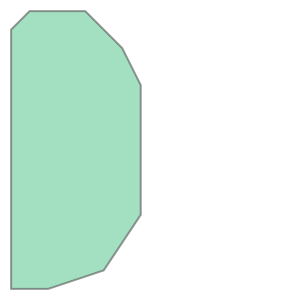

In [474]:
region_hull

In [ ]:
#out_gdf = gpd.GeoDataFrame({"region":[region_id]}, geometry=[region_hull], crs=region_hulls.crs)
#out_gdf.to_file("D:/Work/Github_Morphotopes/data/dortmund_hull.gpkg", driver="GPKG")

# (optional) also save as parquet
#out_gdf.to_parquet("D:/Work/Github_Morphotopes/data/dortmund_hull.parquet")

In [ ]:
# gpd.GeoSeries([region_hull], name='geometry', crs='epsg:3035').explore()